# ResNet-D Constructor
### В пайплайне используется контруктор ResNetD сетей и некоторые трюки, взятые из статьи [Bag of Tricks](https://arxiv.org/pdf/1812.01187.pdf)
#### Загрузка и просмотр датасета лежат в [этом ноутбуке](ResNet_constructor.ipynb) 
- Accuracy на тестовом датасете составляет 93.4%

### Oсновые блоки
[Загрузка датасета](#Загрузка-датасета) <br>
[Гиперпараметры обучения](#Гиперпараметры-обучения) <br>
[Просмотр датасета](#Просмотр-датасета) <br>
[Создание модели](#Создание-модели) <br>
[Тренировочный цикл](#Тренировочный-цикл) <br>
[Проверка модели](#Проверка-модели) <br>
[Критика](#Критика)

In [1]:
import time
import warnings
import os

import numpy as np
import pandas as pd
import torch
from torch import nn
from torchvision import transforms, datasets, utils
from fastai.vision.all import untar_data, URLs

from modules import datasets_loader, CNN_constructor, train_tools

warnings.filterwarnings('ignore')

### Загрузка датасета

In [2]:
dataset_path = untar_data(URLs.IMAGENETTE_320, dest='../imagenette/')
print(f'Imagenette dataset save to: {dataset_path}')

- eсли нужно установить fastai, то можете использовать команду <br>
'conda install -c fastai -c pytorch fastai'

## Гиперпараметры обучения

In [3]:
# hyper params
batch_size = 32
num_epoch = 405
optimizer_type = 'Adam' # 'SGD' or 'Adam' or 'AdamW'
label_smoothing = 0.1 # 0 for disable label_smoothing
activation = 'swish' # 'relu' or 'sigmoid' or 'swish'

# neural network architecture
resnet_layers = [3, 4, 6, 3]
bottleneck = False
num_classes = 10
resnet_type = 'D' 

# learning rate
learning_rate = 0.001 # 0.1 * batch_size / 256
warmup_epoch = 5
scheduler_type = 'cos'
cosine_cycles = 2
decay_steps = 5

# misc
save_best_model = True
save_model_dir = './models/'
metrics_dir = './metrics/'
dataset_path = '../imagenette/imagenette2-320/'

torch.set_num_threads(8)

### Гиперпараметры_обучения
- batch_size: кол-во изображений в одном батче. Предел зависит от кол-ва памяти на видеокарте
- num_epoch: кол-во эпох обучения. Желательно добавлять к плановому количеству warmup_epoch
- optimizer_type: тип оптимизатора, использующегося для обновления весов сети. Может быть 'SGD' или 'Adam'
- label_smoothing: параметр сдвига целевой вероятности (epsilon). Подробности в статье Bag of Tricks

<b>Архитектура сети:
 - layers: список с количеством стандартных блоков по слоям
 - bottleneck: определяет использование стандартных блоков или 'bottleneck' блоков 
 - num_classes: количество предсказываемых классов<br>
(!) Сеть ожидает на вход изображение с разрешением 224х224х3

<b>Изменения скорости обучения
 - learning_rate: базовая скорость обучения
 - warmup_epoch: количество эпох, в течении которых происходит увеличение скорости обучения с 0 до базового значения

Реализовано две стратегии 'cos' - согласно функции косинуса и 'step' - ступенчатое уменьшение скорости обучения в 10 раз через равные промежутки.
- sheduler_type: задает стратегию изменения скорости обучения в течении обучения. может быть 'cos' или 'step'
- cosine_cycles: задает кол-во циклов изменения learning rate при косинусном уменьшении ('cos'). Должно быть меньше или равно num_epoch.<br> 
- decay_steps: количество шагов уменьшения learning rate при ступенчатом уменьшении ('step'). Должно быть меньше или равно num_epoch.<br> 

<b>Прочее
- save_best_model: нужно ли сохранять лучшую модель в процессе обучения. False приведет к сохранению модели в конце обучения
- save_model_dir: путь к папке, в которую сохраняются модели
- save_metrics_dir: путь к папке, в которую сохраняются метрики обучения
- dataset_path: путь к папке с датасетом

### Примеры стандартных сетей:<br>
<b>ResNet-18: </b> <br> 
model = ResNet_like(layers=[2, 2, 2, 2], bottleneck=False, num_classes=10)

<b>ResNet-34: </b> <br> 
model = ResNet_like(resnet_layers=[3, 4, 6, 3], bottleneck=False, num_classes=10)

<b>ResNet-50: </b> <br> 
model = ResNet_like(resnet_layers=[3, 4, 6, 3], bottleneck=True, num_classes=10)

<b>ResNet-101: </b> <br> 
model = ResNet_like(resnet_layers=[3, 4, 23, 3], bottleneck=True, num_classes=10)

<b>ResNet-152: </b> <br> 
model = ResNet_like(resnet_layers=[3, 8, 36, 3], bottleneck=True, num_classes=10)

#### Примеры пользовательских архитектур:<br>
<b>ResNet-11: </b> <br> 
model = ResNet_like(layers=[3, 3, 3], bottleneck=False, num_classes=10)
    
<b>ResNet-42: </b> <br> 
model = ResNet_like(layers=[3, 5, 9, 3], bottleneck=False, num_classes=10)
    
<b>ResNet-74: </b> <br>
model = ResNet_like(layers=[3, 4, 6, 8, 3], bottleneck=True, num_classes=10)

---

<b>Название модели</b><br>
Создаем название модели, которое будет фигурировать в названии сохраненных файлов метрики и модели<br>
Название модели является производным от гиперпараметров

In [4]:
m = 3 if bottleneck else 2
n = cosine_cycles if scheduler_type == 'cos' else decay_steps
model_name = f'ResNet{sum(resnet_layers)*m + 2}_{optimizer_type}_{activation}_lr{learning_rate}_b{batch_size}_{scheduler_type}_sc{(num_epoch-5)//n}'
print(f'model name is {model_name}')

model name is ResNet34_Adam_swish_lr0.001_b32_cos_sc200


### Просмотр датасета

Посмотрим csv, приложенный к датасету

In [5]:
labels_df = pd.read_csv(dataset_path + '/noisy_imagenette.csv')
labels_df.head()

,path,noisy_labels_0,noisy_labels_1,noisy_labels_5,noisy_labels_25,noisy_labels_50,is_valid
0,train/n02979186/n02979186_9036.JPEG,n02979186,n02979186,n02979186,n02979186,n02979186,False
1,train/n02979186/n02979186_11957.JPEG,n02979186,n02979186,n02979186,n02979186,n03000684,False
2,train/n02979186/n02979186_9715.JPEG,n02979186,n02979186,n02979186,n03417042,n03000684,False
3,train/n02979186/n02979186_21736.JPEG,n02979186,n02979186,n02979186,n02979186,n03417042,False
4,train/n02979186/ILSVRC2012_val_00046953.JPEG,n02979186,n02979186,n02979186,n02979186,n03394916,False


В приложенном датасете указаны пути к картинкам и их лейблы. <br>
Цифра после noisy_labels_ означает уровень зашумленности правильных ответов, т.е. noisy_labels_25 означает, что 25% правильных ответов - неправильные.

В этом ноутбуке мы будем работать без зашумления правильных ответов, т.е. нас интересует колонка 'noisy_labels_0'. <br>
Давайте посмотрим сколько уникальных классов находится в этом датасете.

In [6]:
print('Unique labels in Imagenette is', len(labels_df['noisy_labels_0'].unique()))

Unique labels in Imagenette is 10


Количество картинок в тренировочном датасете

In [7]:
train_img_qty = len(labels_df[labels_df['is_valid'] == False].index)
print(f'Image in train dataset: {train_img_qty}')

Image in train dataset: 9469


Кол-во картинок в тестовом датасете

In [8]:
test_img_qty = len(labels_df[labels_df['is_valid'] == True].index)
print(f'Image in test dataset: {test_img_qty}')

Image in test dataset: 3925


Давайте глянем на примеры картинок в тренировочном датасете

garbage truck


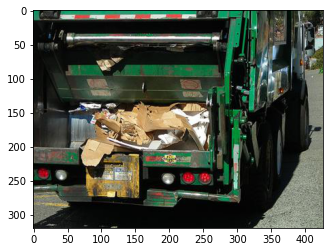

tench


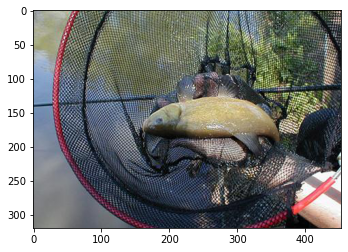

cassette player


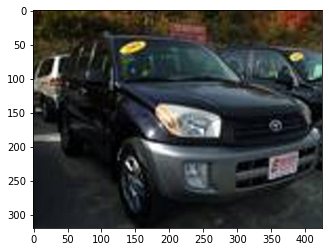

church


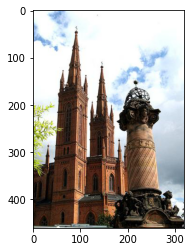

In [9]:
show_subset = datasets.ImageFolder(root=dataset_path + '/train/', transform=transforms.Compose([transforms.ToTensor()]))
show_subset = torch.utils.data.Subset(show_subset, np.random.randint(0, high=len(show_subset), size=4))
show_subset_loader = torch.utils.data.DataLoader(show_subset, shuffle=False)
for images, labels in show_subset_loader:
    print(datasets_loader.label_func(int(labels)))
    datasets_loader.visual_tensor(utils.make_grid(images))

### Предобработка данных

В качестве аугментаций ипользуются:
- вырезание из картинки случайного прямоугольника общей площадью не менее 8% от исходного изображения.
- случайного изменение освещенности, констраста, насыщенности и тона
- случайный переворот изображения по горизонтальной оси
- нормализация

Для тестового датасета используется:
- изменение размера под вход сети
- нормализация

In [10]:
resolution = (14*2**len(resnet_layers), 14*2**len(resnet_layers))

train_transform = transforms.Compose([
        transforms.RandomResizedCrop(resolution, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333)),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
        transforms.RandomHorizontalFlip(.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
test_transform = transforms.Compose([
        transforms.Resize(resolution),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

Создаем тренировочный и тестовый датасет и DataLoader'ы к ним

In [11]:
trainset = datasets.ImageFolder(root=dataset_path + 'train/', transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = datasets.ImageFolder(root=dataset_path + 'val/', transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, shuffle=False)

## Создание модели

Инициализируем модель с через конструктор. <br>

In [12]:
model = CNN_constructor.ResNetLike(layers=resnet_layers, 
                                       resnet_type=resnet_type, 
                                       bottleneck=bottleneck, 
                                       num_classes=num_classes,
                                       activation=activation)

Задаем функцию ошибки. <br>
Задаем оптимизатор. <br>
Задаем планировщики скорости обучения. <br>

In [13]:
criterion = train_tools.SmoothCrossEntropyLoss(smoothing=label_smoothing)
optimizer = train_tools.get_optimizer(model, optimizer_type, learning_rate)
scheduler = train_tools.get_scheduler(optimizer, scheduler_type, step_len=num_epoch//decay_steps, cycle_len=num_epoch//cosine_cycles)
if warmup_epoch:
    scheduler_warmup = train_tools.get_scheduler(optimizer, 
                                                'warmup', 
                                                learning_rate=learning_rate, 
                                                batch_per_epoch=len(trainloader), 
                                                warmup_epoch=warmup_epoch)

Загружаем модель на видеокарту.

In [14]:
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:4


ResNetLike(
  (first): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (body): Sequential(
    (block_2_1): ResNetNormalBlock(
      (activation): SiLU()
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, moment

Создадим папки для сохранения моделей и метрик

In [15]:
datasets_loader.create_dir(save_model_dir)
datasets_loader.create_dir(metrics_dir)                  

already created
already created


Создаем датафрейм для записи метрик обучения. <br>
Датафрейм сохраняется в папку './metrics'

In [16]:
cols_name = ['epoch', 'time', 'current_lr', 'loss', 'accuracy_train', 'accuracy_val']
metrics_frame = pd.DataFrame(columns=cols_name)
metrics_frame_file = (metrics_dir + model_name + '.csv')
print(f'File with train metrics save to {metrics_frame_file}')

File with train metrics save to ./metrics/ResNet34_Adam_swish_lr0.001_b32_cos_sc200.csv


## Тренировочный цикл

- Основная метрика accuracy (топ1).<br>
- В цикле используется упрощенный подсчет accuracy в конце каждой эпохи для ускорения обучения.<br>
Если в конце эпохи ускоренный подсчет показывает интересный результат, то метрика на тестовом датасете будет пересчитана честно.
- Сохранение модели

In [ ]:
for epoch in range(num_epoch):  # loop over the dataset multiple times
    # train cycle
    model.train()
    start_time = time.time()
    for data in trainloader:
        loss, outputs = train_tools.make_step(data, optimizer, model, criterion, device)
        if epoch < warmup_epoch:
            scheduler_warmup.step()
    if epoch >= warmup_epoch:
        scheduler.step()
    
    # metrics calc
    model.eval()
    accuracy_train = train_tools.approx_accuracy(trainset, model, device, denominator=16)
    accuracy_val = train_tools.approx_accuracy(testset, model, device, denominator=4)
    
    if accuracy_val >= .88 and accuracy_val >= metrics_frame['accuracy_val'].max():
        accuracy_val = train_tools.true_accuracy(testloader, model, device)

    end_time = time.time()
    metrics = {'epoch': epoch+1,
               'time': end_time - start_time,
               'current_lr': [group['lr'] for group in optimizer.param_groups][0],
               'loss': float(loss),
               'accuracy_train': accuracy_train,
               'accuracy_val': accuracy_val,
               }

    print("Epoch {}/{}, Time: {:.2f} sec, current_lr: {:.2e}, Loss: {:.3f}, Accuracy_train: {:.3f}, Accuracy_val: {:.3f}".
          format(metrics['epoch'], num_epoch, metrics['time'], metrics['current_lr'], metrics['loss'], metrics['accuracy_train'], metrics['accuracy_val']))
    
    metrics_frame = metrics_frame.append(pd.DataFrame.from_dict(metrics, orient='index').T)
    metrics_frame.to_csv(metrics_frame_file, index=False)
    
    if save_best_model:
        if metrics['accuracy_val'] == metrics_frame['accuracy_val'].max():
            torch.save(model, save_model_dir + model_name + '.pt')
if not save_best_model:
    torch.save(model, save_model_dir + model_name + '.pt')

Epoch 1/405, Time: 119.26 sec, current_lr: 2.00e-04, Loss: 1.912, Accuracy_train: 0.298, Accuracy_val: 0.302
Epoch 2/405, Time: 118.07 sec, current_lr: 3.99e-04, Loss: 1.903, Accuracy_train: 0.359, Accuracy_val: 0.402
Epoch 3/405, Time: 118.23 sec, current_lr: 5.98e-04, Loss: 1.922, Accuracy_train: 0.423, Accuracy_val: 0.376
Epoch 4/405, Time: 118.33 sec, current_lr: 7.97e-04, Loss: 1.725, Accuracy_train: 0.558, Accuracy_val: 0.540
Epoch 5/405, Time: 118.24 sec, current_lr: 9.97e-04, Loss: 1.731, Accuracy_train: 0.496, Accuracy_val: 0.516
Epoch 6/405, Time: 118.04 sec, current_lr: 1.00e-03, Loss: 1.642, Accuracy_train: 0.516, Accuracy_val: 0.588
Epoch 7/405, Time: 117.86 sec, current_lr: 1.00e-03, Loss: 1.632, Accuracy_train: 0.591, Accuracy_val: 0.638
Epoch 8/405, Time: 117.93 sec, current_lr: 9.99e-04, Loss: 1.580, Accuracy_train: 0.602, Accuracy_val: 0.643
Epoch 9/405, Time: 118.15 sec, current_lr: 9.99e-04, Loss: 1.463, Accuracy_train: 0.623, Accuracy_val: 0.692
Epoch 10/405, Time:

### Проверка модели

Посмотрим сохраненные в процессе обучения метрики

In [ ]:
metrics_frame.tail()

Посмотрим лучший результат на валидации

In [ ]:
metrics_frame[metrics_frame['accuracy_val'] == metrics_frame['accuracy_val'].max()]

,epoch,time,current_lr,loss,accuracy_train,accuracy_val
0,365.0,179.553266,0.000113,0.624626,0.959391,0.934013


Проверим сохраненную модель на соответствие метрикам в процессе обучения.

In [24]:
model = torch.load(save_model_dir + model_name + '.pt')
model = model.eval()

In [25]:
accuracy_check = train_tools.true_accuracy(testloader, model, device)

print(f'Accuracy saved model on the validation dataset is: {accuracy_check:.3f}')

Accuracy saved model on the validation dataset is: 0.934


##### Использование трюков из статьи увеличило результат на 1,3 %

### Критика

Известные проблемы:
- результат все еще ниже baseline от fastai на 2 пункта
- агументации сильно увеличивают время обучения (+50%)
- прирост accuracy от использования трюков отмечен только для cosine learning decay (sheduler_type = 'cos')
- результат очень сильно зависит от стартового learning_rate. learning_rate для используемых оптимизаторов нужно выбирать в разном диапазоне (0,01-0,1 для SGD и 0,0005-0,03 для Adam), что приводит к некоторой путанице
- метрика, посчитанная при проверке модели может отличаться от сохраненной в процессе обучения <br>
Это происходит если в процессе обучения метрика считается только с помощью approx_accuracy()
- увеличение количества гиперпараметров усложняет поиск опптимальных значений

# 